In [8]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf # includes all relevant methods (OLS, etc.)
import patsy
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
### 1. LOAD CSV FILES (DataHub)
patients = pd.read_csv("patients.csv")
medications = pd.read_csv("medications.csv")
encounters = pd.read_csv("encounters.csv")
observations = pd.read_csv("observations.csv")
conditions = pd.read_csv("conditions.csv")
procedures = pd.read_csv("procedures.csv")  # if needed later

### 2. RENAME KEY COLUMNS FOR CONSISTENCY
patients = patients.rename(columns={'Id': 'patient_id'})
for df_sub in [medications, encounters, observations, conditions]:
    df_sub.rename(columns={'PATIENT': 'patient_id'}, inplace=True) # different csvs said different things

In [10]:
### 3. BUILD BASE PATIENT DATA WITH DEMOGRAPHICS, RACE/ETHNICITY, INSURANCE, & MORTALITY
# Use both RACE and ETHNICITY columns; note that ETHNICITY is in all caps.
patients_subset = patients[['patient_id', 'RACE', 'ETHNICITY', 'GENDER', 'INCOME', 'BIRTHDATE', 
                              'HEALTHCARE_COVERAGE', 'DEATHDATE']].copy() 

# Convert BIRTHDATE and compute AGE.
patients_subset.loc[:, 'BIRTHDATE'] = pd.to_datetime(patients_subset['BIRTHDATE'], errors='coerce')
patients_subset.loc[:, 'AGE'] = patients_subset['BIRTHDATE'].apply(
    lambda x: (pd.Timestamp('today') - x).days // 365 if pd.notnull(x) else np.nan
)

# # Create mortality indicator.
# patients_subset['mortality'] = patients_subset['DEATHDATE'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Convert RACE, GENDER, and ETHNICITY to categorical.
patients_subset.loc[:, 'RACE'] = patients_subset['RACE'].astype('category')
patients_subset.loc[:, 'GENDER'] = patients_subset['GENDER'].astype('category')
patients_subset.loc[:, 'ETHNICITY'] = patients_subset['ETHNICITY'].astype('category')

# Create composite race/ethnicity:
# If ETHNICITY (all caps) is "Hispanic" (ignoring case), then label as "Hispanic"; otherwise use RACE.
patients_subset['race_ethnicity'] = np.where(
    patients_subset['ETHNICITY'].str.lower() == "hispanic", 
    "Hispanic", 
    patients_subset['RACE']
)
patients_subset['race_ethnicity'] = patients_subset['race_ethnicity'].astype('category')

# Drop rows with missing key values.
patients_subset = patients_subset.dropna(subset=['INCOME', 'HEALTHCARE_COVERAGE', 'AGE'])

In [11]:
### 4. AGGREGATE OUTCOME VARIABLES
# 4a. Encounter Count (all encounters)
encounter_count = encounters.groupby('patient_id').size().reset_index(name='encounter_count')

# 4b. Medication Adherence: Total dispenses.
dispenses_agg = medications.groupby('patient_id', as_index=False)['DISPENSES'].sum().rename(
    columns={'DISPENSES': 'total_dispenses'}
)

# 4c. Glycemic Control (Observed HbA1c)
observations['DESCRIPTION_lower'] = observations['DESCRIPTION'].str.lower()
mask_a1c = observations['DESCRIPTION_lower'].str.contains('a1c', na=False) & (~observations['DESCRIPTION_lower'].str.contains('glucose', na=False))
a1c_obs = observations[mask_a1c].copy()
a1c_obs['numeric_HbA1c'] = pd.to_numeric(a1c_obs['VALUE'], errors='coerce')

mask_glucose = observations['DESCRIPTION_lower'].str.contains('glucose', na=False)
glucose_obs = observations[mask_glucose].copy()
glucose_obs['numeric_glucose'] = pd.to_numeric(glucose_obs['VALUE'], errors='coerce')
glucose_obs['converted_HbA1c'] = (glucose_obs['numeric_glucose'] + 46.7) / 28.7

a1c_grouped = a1c_obs.groupby('patient_id', as_index=False)['numeric_HbA1c'].mean() # one val per patient
glucose_grouped = glucose_obs.groupby('patient_id', as_index=False)['converted_HbA1c'].mean()
combined_a1c = pd.merge(a1c_grouped, glucose_grouped, on='patient_id', how='outer')

def combine_a1c(row):
    if pd.notna(row['numeric_HbA1c']) and pd.notna(row['converted_HbA1c']):
        return (row['numeric_HbA1c'] + row['converted_HbA1c']) / 2
    elif pd.notna(row['numeric_HbA1c']):
        return row['numeric_HbA1c']
    else:
        return row['converted_HbA1c'] # more averaging

combined_a1c['observed_HbA1c'] = combined_a1c.apply(combine_a1c, axis=1)
combined_a1c = combined_a1c[['patient_id', 'observed_HbA1c']] 

# 4d. Process Encounter-Level Cost Data.
hospital_encounters = encounters[encounters['ENCOUNTERCLASS'].isin(['inpatient', 'emergency'])].copy()
hospital_encounters['net_encounter_cost'] = hospital_encounters['TOTAL_CLAIM_COST'] - hospital_encounters['PAYER_COVERAGE']
hospital_costs = hospital_encounters.groupby('patient_id').agg({
    'net_encounter_cost': 'sum',
    'ENCOUNTERCLASS': 'count'
}).reset_index().rename(columns={'ENCOUNTERCLASS': 'hospitalization_count_new'})

In [12]:
### 5. MERGE OUTCOME VARIABLES WITH PATIENT DATA
df = patients_subset.merge(encounter_count, on='patient_id', how='left') \
                    .merge(dispenses_agg, on='patient_id', how='left') \
                    .merge(combined_a1c, on='patient_id', how='left') \
                    .merge(hospital_costs, on='patient_id', how='left')
df['encounter_count'] = df['encounter_count'].fillna(0)
df['total_dispenses'] = df['total_dispenses'].fillna(0)
df['net_encounter_cost'] = df['net_encounter_cost'].fillna(0)
df['hospitalization_count_new'] = df['hospitalization_count_new'].fillna(0)
df = df.dropna(subset=['observed_HbA1c'])

### 6. STANDARDIZE KEY PREDICTORS - kinda like the curve!
df['INCOME_std'] = (df['INCOME'] - df['INCOME'].mean()) / df['INCOME'].std()
df['COVERAGE_std'] = (df['HEALTHCARE_COVERAGE'] - df['HEALTHCARE_COVERAGE'].mean()) / df['HEALTHCARE_COVERAGE'].std()
df['AGE_std'] = (df['AGE'] - df['AGE'].mean()) / df['AGE'].std()
# Uncomment if HEALTHCARE_EXPENSES exists:
# df['HEALTHCARE_EXPENSES'] = pd.to_numeric(df['HEALTHCARE_EXPENSES'], errors='coerce')
# df['EXPENSES_std'] = (df['HEALTHCARE_EXPENSES'] - df['HEALTHCARE_EXPENSES'].mean()) / df['HEALTHCARE_EXPENSES'].std()

In [13]:
### 7. CREATE INSULIN & HOSPITAL COST-TO-INCOME RATIOS
# (a) Insulin cost-to-income ratio from medications.
medications['DESCRIPTION_lower'] = medications['DESCRIPTION'].str.lower()
insulin_mask = medications['DESCRIPTION_lower'].str.contains('insulin', na=False)
insulin_df = medications[insulin_mask].copy()
insulin_cost_agg = insulin_df.groupby('patient_id', as_index=False)['TOTALCOST'].sum()
insulin_cost_agg.rename(columns={'TOTALCOST': 'total_insulin_cost'}, inplace=True)
df = df.merge(insulin_cost_agg, on='patient_id', how='left')
df['total_insulin_cost'] = df['total_insulin_cost'].fillna(0)
df.loc[df['INCOME'] <= 0, 'INCOME'] = np.nan
df['insulin_cost_income_ratio'] = df['total_insulin_cost'] / df['INCOME']
df['insulin_cost_income_ratio'] = df['insulin_cost_income_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['cost_income_std'] = (df['insulin_cost_income_ratio'] - df['insulin_cost_income_ratio'].mean()) / df['insulin_cost_income_ratio'].std()

# (b) Hospital cost-to-income ratio from encounters.
df['hospital_cost_income_ratio'] = df['net_encounter_cost'] / df['INCOME']
df['hospital_cost_income_ratio'] = df['hospital_cost_income_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['hospital_cost_income_std'] = (df['hospital_cost_income_ratio'] - df['hospital_cost_income_ratio'].mean()) / df['hospital_cost_income_ratio'].std()

In [14]:
### 8. EXTRACT COMORBIDITY INDICATORS FROM CONDITIONS
conditions['DESCRIPTION'] = conditions['DESCRIPTION'].astype(str)
conditions['description_lower'] = conditions['DESCRIPTION'].str.lower()

def create_indicator(df_sub, keyword_pattern, col_name):
    mask = df_sub['description_lower'].str.contains(keyword_pattern, na=False)
    temp = df_sub[mask].copy()
    indicator = temp.groupby('patient_id').size().reset_index(name=col_name + '_count')
    indicator[col_name] = (indicator[col_name + '_count'] > 0).astype(int)
    return indicator[['patient_id', col_name]]

htn_indicator = create_indicator(conditions, 'hypertension', 'has_hypertension')
kidney_indicator = create_indicator(conditions, 'kidney|renal|nephropathy', 'has_kidney_disorder')
proteinuria_indicator = create_indicator(conditions, 'proteinuria', 'has_proteinuria')
retinopathy_indicator = create_indicator(conditions, 'retinopathy', 'has_retinopathy')
neuropathy_indicator = create_indicator(conditions, 'neuropathy', 'has_neuropathy')
sleep_apnea_indicator = create_indicator(conditions, 'sleep apnea', 'has_sleep_apnea')
obesity_indicator = create_indicator(conditions, 'obese', 'has_obesity')

for indicator_df in [htn_indicator, kidney_indicator, proteinuria_indicator,
                     retinopathy_indicator, neuropathy_indicator, sleep_apnea_indicator,
                     obesity_indicator]:
    df = df.merge(indicator_df, on='patient_id', how='left')
for col in ['has_hypertension', 'has_kidney_disorder', 'has_proteinuria',
            'has_retinopathy', 'has_neuropathy', 'has_sleep_apnea', 'has_obesity']:
    df[col] = df[col].fillna(0).astype(int)

In [15]:
### 9. EXTRACT BIOMARKER VALUES FROM OBSERVATIONS
observations['DESCRIPTION_lower'] = observations['DESCRIPTION'].str.lower()

# Extract BMI.
bmi_mask = observations['DESCRIPTION_lower'].str.contains('body mass index', na=False) | observations['DESCRIPTION_lower'].str.contains('bmi', na=False)
bmi_obs = observations[bmi_mask].copy()
bmi_obs['BMI'] = pd.to_numeric(bmi_obs['VALUE'], errors='coerce')
bmi_grouped = bmi_obs.groupby('patient_id', as_index=False)['BMI'].mean()

# Extract systolic blood pressure.
sys_mask = observations['DESCRIPTION_lower'].str.contains('systolic blood pressure', na=False)
sys_obs = observations[sys_mask].copy()
sys_obs['systolic_bp'] = pd.to_numeric(sys_obs['VALUE'], errors='coerce')
sys_grouped = sys_obs.groupby('patient_id', as_index=False)['systolic_bp'].mean()

# Extract diastolic blood pressure.
dia_mask = observations['DESCRIPTION_lower'].str.contains('diastolic blood pressure', na=False)
dia_obs = observations[dia_mask].copy()
dia_obs['diastolic_bp'] = pd.to_numeric(dia_obs['VALUE'], errors='coerce')
dia_grouped = dia_obs.groupby('patient_id', as_index=False)['diastolic_bp'].mean()

# Extract triglycerides.
tri_mask = observations['DESCRIPTION_lower'].str.contains('triglyceride', na=False)
tri_obs = observations[tri_mask].copy()
tri_obs['triglycerides'] = pd.to_numeric(tri_obs['VALUE'], errors='coerce')
tri_grouped = tri_obs.groupby('patient_id', as_index=False)['triglycerides'].mean()

# Extract heart rate.
hr_mask = observations['DESCRIPTION_lower'].str.contains('heart rate', na=False)
hr_obs = observations[hr_mask].copy()
hr_obs['heart_rate'] = pd.to_numeric(hr_obs['VALUE'], errors='coerce')
hr_grouped = hr_obs.groupby('patient_id', as_index=False)['heart_rate'].mean()

for biomarker in [bmi_grouped, sys_grouped, dia_grouped, tri_grouped, hr_grouped]:
    df = df.merge(biomarker, on='patient_id', how='left')

df['BMI_std'] = (df['BMI'] - df['BMI'].mean()) / df['BMI'].std()
df['systolic_bp_std'] = (df['systolic_bp'] - df['systolic_bp'].mean()) / df['systolic_bp'].std()
df['diastolic_bp_std'] = (df['diastolic_bp'] - df['diastolic_bp'].mean()) / df['diastolic_bp'].std()
df['triglycerides_std'] = (df['triglycerides'] - df['triglycerides'].mean()) / df['triglycerides'].std()
df['heart_rate_std'] = (df['heart_rate'] - df['heart_rate'].mean()) / df['heart_rate'].std()

In [16]:
### 10. FILTER FOR DIABETES PATIENTS
diabetes_indicator = create_indicator(conditions, 'diabetes', 'has_diabetes')
df = df.merge(diabetes_indicator, on='patient_id', how='left')
df['has_diabetes'] = df['has_diabetes'].fillna(0).astype(int)
df = df[df['has_diabetes'] == 1]

### 11. TYPES OF VISITS ANALYSIS (WITH PROPORTIONS)
df['income_quantile'] = pd.qcut(df['INCOME'], q=4, labels=["Low", "Medium", "High", "Very High"])
diabetes_encounters = encounters[encounters['patient_id'].isin(df['patient_id'])].copy()
diabetes_encounters = diabetes_encounters.merge(df[['patient_id', 'income_quantile']],
                                                on='patient_id', how='left')
visit_counts = diabetes_encounters.groupby(['income_quantile', 'ENCOUNTERCLASS']).size().reset_index(name='count')
total_visits = visit_counts.groupby('income_quantile')['count'].sum().reset_index(name='total')
visit_counts = visit_counts.merge(total_visits, on='income_quantile', how='left')
visit_counts['proportion'] = (visit_counts['count'] / visit_counts['total']) * 100
sns.set_style("whitegrid")

/tmp/ipykernel_78/1361030371.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visit_counts = diabetes_encounters.groupby(['income_quantile', 'ENCOUNTERCLASS']).size().reset_index(name='count')
/tmp/ipykernel_78/1361030371.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_visits = visit_counts.groupby('income_quantile')['count'].sum().reset_index(name='total')


In [17]:
### 12. PROPORTION-BASED MODEL FOR HOSPITALIZATIONS
df['non_hospital_encounters'] = (df['encounter_count'] - df['hospitalization_count_new']).clip(lower=0)
hospital_prop_formula = (
    "hospitalization_count_new + non_hospital_encounters ~ C(race_ethnicity) + INCOME_std + COVERAGE_std + "
    "has_hypertension + has_kidney_disorder + has_proteinuria + "
    "has_retinopathy + has_neuropathy + has_sleep_apnea + cost_income_std"
)
hospital_prop_model = smf.glm(
    formula=hospital_prop_formula,
    data=df,
    family=sm.families.Binomial()
).fit()
print("\nBinomial Model for Hospitalization Proportion:")
print(hospital_prop_model.summary())


Binomial Model for Hospitalization Proportion:
                                    Generalized Linear Model Regression Results                                     
Dep. Variable:     ['hospitalization_count_new', 'non_hospital_encounters']   No. Observations:                   38
Model:                                                                  GLM   Df Residuals:                       24
Model Family:                                                      Binomial   Df Model:                           13
Link Function:                                                        Logit   Scale:                          1.0000
Method:                                                                IRLS   Log-Likelihood:                -74.281
Date:                                                      Wed, 14 May 2025   Deviance:                       51.883
Time:                                                              15:53:04   Pearson chi2:                     58.3
No. Iterations: 

In [18]:
### 13. POISSON MODEL FOR MEDICATION ADHERENCE (Raw Counts)
adherence_formula = (
    "total_dispenses ~ C(race_ethnicity) + INCOME_std + COVERAGE_std + "
    "has_hypertension + has_kidney_disorder + has_proteinuria + "
    "has_retinopathy + has_neuropathy + has_sleep_apnea + cost_income_std"
)
adherence_model = smf.glm(adherence_formula, data=df, family=sm.families.Poisson()).fit()
print("\nPoisson Regression Model for Medication Adherence (Socioeconomic & Race Focus):")
print(adherence_model.summary())


Poisson Regression Model for Medication Adherence (Socioeconomic & Race Focus):
                 Generalized Linear Model Regression Results                  
Dep. Variable:        total_dispenses   No. Observations:                   38
Model:                            GLM   Df Residuals:                       24
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7413.0
Date:                Wed, 14 May 2025   Deviance:                       14553.
Time:                        15:53:16   Pearson chi2:                 2.05e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

In [19]:
### 14. OLS MODEL FOR GLYCEMIC CONTROL (Observed HbA1c)
glycemic_formula = (
    "observed_HbA1c ~ C(race_ethnicity) + INCOME_std + COVERAGE_std + "
    "has_hypertension + has_kidney_disorder + has_proteinuria + "
    "has_retinopathy + has_neuropathy + has_sleep_apnea + cost_income_std + "
    "BMI_std + systolic_bp_std + diastolic_bp_std + triglycerides_std + heart_rate_std"
)
glycemic_model = smf.ols(glycemic_formula, data=df).fit()
print("\nOLS Regression Model for Glycemic Control (Observed HbA1c, Socioeconomic & Race Focus):")
print(glycemic_model.summary())


OLS Regression Model for Glycemic Control (Observed HbA1c, Socioeconomic & Race Focus):
                            OLS Regression Results                            
Dep. Variable:         observed_HbA1c   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     84.30
Date:                Wed, 14 May 2025   Prob (F-statistic):           3.93e-13
Time:                        15:53:58   Log-Likelihood:                 28.969
No. Observations:                  36   AIC:                            -19.94
Df Residuals:                      17   BIC:                             10.15
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [20]:
complications_keywords = "ketoacidosis|foot ulcer|cardiovascular|heart disease|myocardial infarction|stroke"
diabetes_complication_indicator = create_indicator(conditions, complications_keywords, "has_diabetes_complication")
df = df.merge(diabetes_complication_indicator, on='patient_id', how='left')
df['has_diabetes_complication'] = df['has_diabetes_complication'].fillna(0).astype(int)
complication_formula = ("has_diabetes_complication ~ C(race_ethnicity) + INCOME_std + COVERAGE_std + cost_income_std")
# complication_model = smf.logit(complication_formula, data=df).fit()
# print("\nLogistic Regression Model for Diabetes Complications (Socioeconomic & Race Focus):")
# print(complication_model.summary())

### 16. (OPTIONAL) CHECK MULTICOLLINEARITY FOR EACH MODEL
def print_vif(formula, data, model_name):
    y_out, X_out = patsy.dmatrices(formula, data=data, return_type='dataframe')
    vif_df = pd.DataFrame()
    vif_df["feature"] = X_out.columns
    vif_df["VIF"] = [variance_inflation_factor(X_out.values, i) for i in range(X_out.shape[1])]
    print(f"\nVariance Inflation Factors for {model_name}:")
    print(vif_df)

print_vif(hospital_prop_formula, df, "Hospitalization Proportion Model")
print_vif(adherence_formula, df, "Adherence Model (Socioeconomic & Race Focus)")
print_vif(glycemic_formula, df, "Glycemic Control Model (Socioeconomic & Race Focus)")
# print_vif(mortality_formula_simple, df, "Mortality Model (Socioeconomic & Race Focus)")
# print_vif(complication_formula, df, "Diabetes Complications Model (Socioeconomic & Race Focus)")

#Some portions of the code were developed or refined with the assistance of OpenAI's ChatGPT, used as a research assistant to support model implementation and documentation.


Variance Inflation Factors for Hospitalization Proportion Model:
                        feature        VIF
0                     Intercept  10.923047
1    C(race_ethnicity)[T.asian]   1.865959
2    C(race_ethnicity)[T.black]   2.220080
3   C(race_ethnicity)[T.native]        NaN
4    C(race_ethnicity)[T.other]   2.113700
5    C(race_ethnicity)[T.white]   2.512464
6                    INCOME_std   1.779533
7                  COVERAGE_std   1.517891
8              has_hypertension   2.178428
9           has_kidney_disorder   4.602247
10              has_proteinuria   4.766798
11              has_retinopathy   1.573940
12               has_neuropathy   1.781635
13              has_sleep_apnea   1.545172
14              cost_income_std   1.955156

Variance Inflation Factors for Adherence Model (Socioeconomic & Race Focus):
                        feature        VIF
0                     Intercept  10.923047
1    C(race_ethnicity)[T.asian]   1.865959
2    C(race_ethnicity)[T.black]   2.220

/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/srv/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


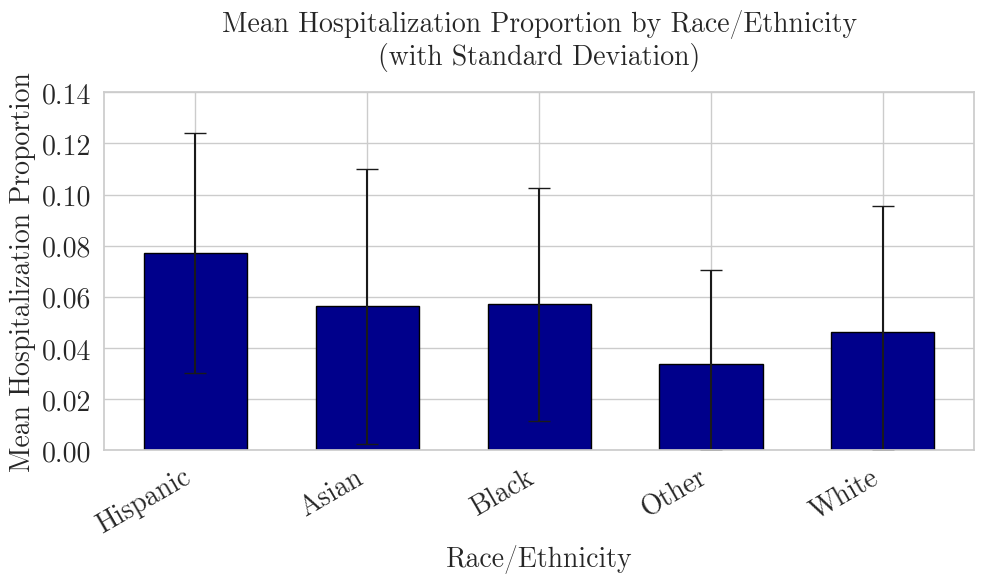

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np

# Load Computer Modern font at 20 pt
font_path = "cmunrm.ttf"
cm_font = fm.FontProperties(fname=font_path, size=20)

# Style settings
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['axes.unicode_minus'] = False

# Compute hospitalization proportion
df['hosp_prop'] = df['hospitalization_count_new'] / df['encounter_count']

# Group stats
group_stats = df.groupby('race_ethnicity', observed=True)['hosp_prop'].agg(['mean', 'std']).reset_index()
group_stats['race_ethnicity'] = group_stats['race_ethnicity'].str.title()

# Clip error bars so they don’t extend below 0
lower_errors = np.minimum(group_stats['std'], group_stats['mean'])  # prevent negative
upper_errors = group_stats['std']
yerr = np.array([lower_errors, upper_errors])  # shape (2, N)

# Plot
sns.set(style="whitegrid")
x = np.arange(len(group_stats))
bar_width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    x,
    group_stats['mean'],
    yerr=yerr,
    capsize=8,
    color='darkblue',
    edgecolor='black',
    width=bar_width
)

# Enforce y-axis start at 0
ax.set_ylim(bottom=0)

# Labeling
ax.set_xticks(x)
ax.set_xticklabels(group_stats['race_ethnicity'], fontproperties=cm_font, rotation=30, ha='right')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f"{tick:.2f}" for tick in ax.get_yticks()], fontproperties=cm_font)

ax.set_ylabel("Mean Hospitalization Proportion", fontproperties=cm_font)
ax.set_xlabel("Race/Ethnicity", fontproperties=cm_font)
ax.set_title("Mean Hospitalization Proportion by Race/Ethnicity\n(with Standard Deviation)", fontproperties=cm_font, pad=20)

# Export
plt.tight_layout()
plt.savefig("Hospitalization_BarPlot_NoNegativeError.pdf", dpi=300, bbox_inches='tight', transparent=True)
plt.savefig("Hospitalization_BarPlot_NoNegativeError.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


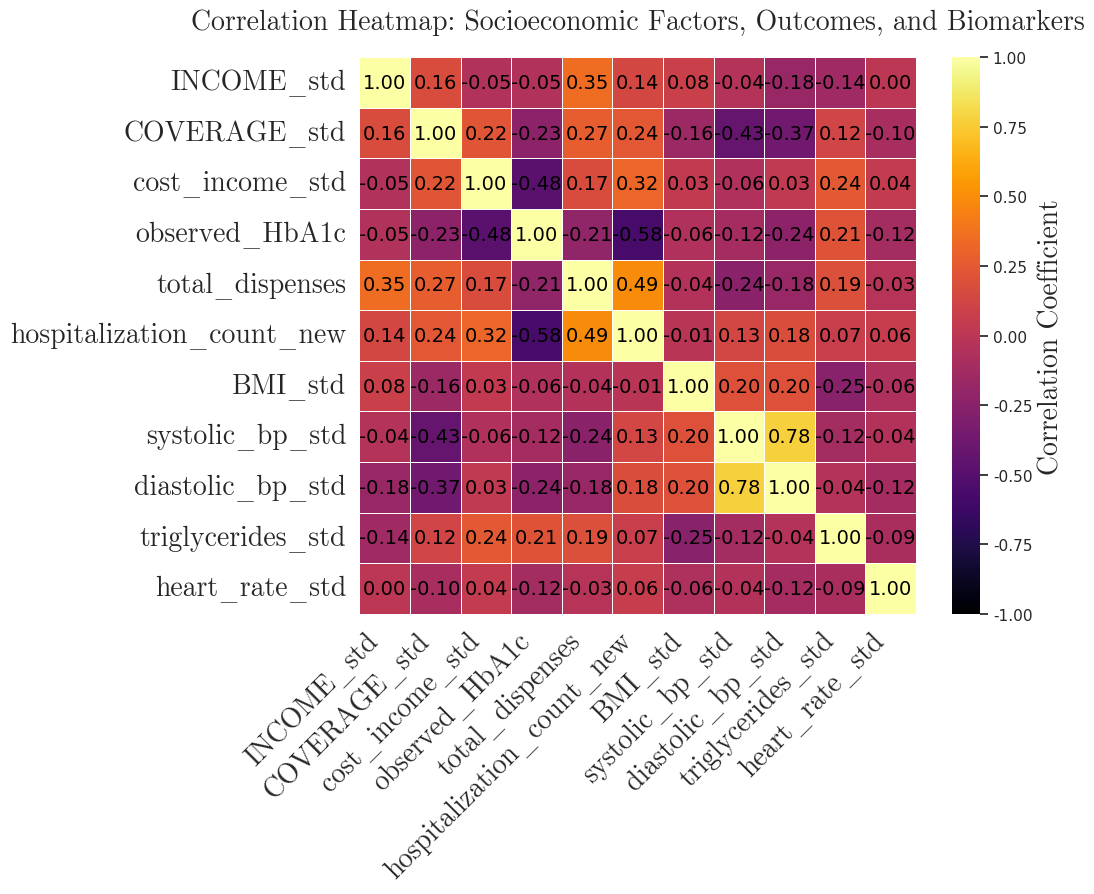

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# Load Computer Modern font at 20 pt
font_path = "cmunrm.ttf"
cm_font = fm.FontProperties(fname=font_path, size=20)

# Configure plot style
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['axes.unicode_minus'] = False

# Variables from your figure description
selected_vars = [
    'INCOME_std',
    'COVERAGE_std',
    'cost_income_std',
    'observed_HbA1c',
    'total_dispenses',
    'hospitalization_count_new',
    'BMI_std',
    'systolic_bp_std',
    'diastolic_bp_std',
    'triglycerides_std',
    'heart_rate_std'
]

# Compute correlation matrix
corr_matrix = df[selected_vars].corr()

# Plot
sns.set(style="white")
plt.figure(figsize=(11, 9))
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="inferno",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    annot_kws={"size":14, "color": "black"},
    cbar_kws={"label": "Correlation Coefficient"}
)

# Set titles and labels
plt.title("Correlation Heatmap: Socioeconomic Factors, Outcomes, and Biomarkers", fontproperties=cm_font, pad=20)
plt.xticks(fontproperties=cm_font, rotation=45, ha='right')
plt.yticks(fontproperties=cm_font, rotation=0)
heatmap.figure.axes[-1].yaxis.label.set_fontproperties(cm_font)  # Colorbar label

# Export
plt.tight_layout()
plt.savefig("Correlation_Heatmap_Clean.pdf", dpi=300, bbox_inches='tight', transparent=True)
plt.savefig("Correlation_Heatmap_Clean.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


/tmp/ipykernel_77/4122760647.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


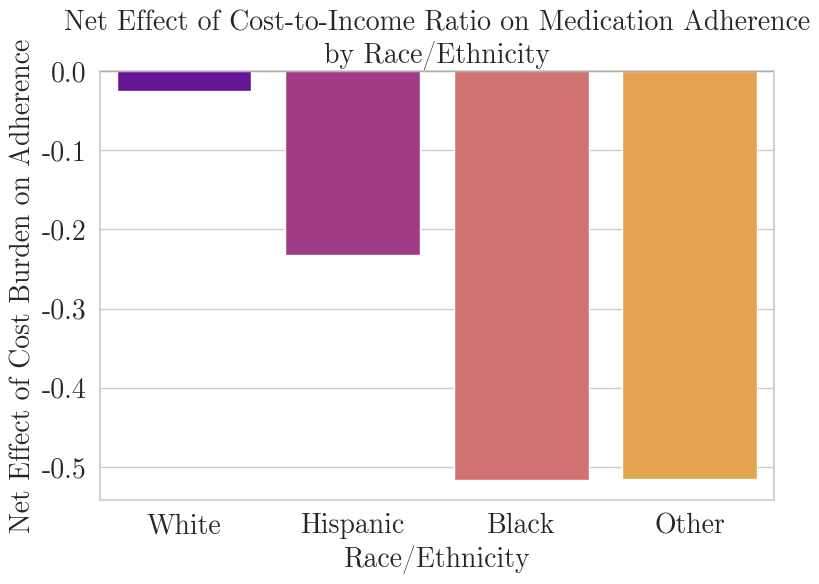

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

# Load Computer Modern font (ensure cmunrm.ttf is uploaded)
font_path = "cmunrm.ttf"
cm_font = fm.FontProperties(fname=font_path, size=20)

# Turn off LaTeX rendering
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['axes.unicode_minus'] = False

# Define the net effects from regression model
net_effects = {
    "White": -0.025,   # -0.233 + 0.208
    "Hispanic": -0.233,
    "Black": -0.516,   # -0.233 - 0.283
    "Other": -0.515    # -0.233 - 0.282
    # "Asian": 0.345,  # Uncomment if needed
}

# Convert to DataFrame
net_df = pd.DataFrame(list(net_effects.items()), columns=["Race/Ethnicity", "Net_Effect"])

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x="Race/Ethnicity",
    y="Net_Effect",
    data=net_df,
    palette="plasma"
)

# Style
ax.axhline(0, color="black", linewidth=1.5)
plt.xlabel("Race/Ethnicity", fontproperties=cm_font)
plt.ylabel("Net Effect of Cost Burden on Adherence", fontproperties=cm_font)
plt.title("Net Effect of Cost-to-Income Ratio on Medication Adherence\nby Race/Ethnicity", fontproperties=cm_font)
plt.xticks(fontproperties=cm_font)
plt.yticks(fontproperties=cm_font)

# Final layout and export
plt.tight_layout()
plt.savefig("Net_Effect_BarPlot.pdf", dpi=300, bbox_inches='tight', transparent=True)
plt.savefig("Net_Effect_BarPlot.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()



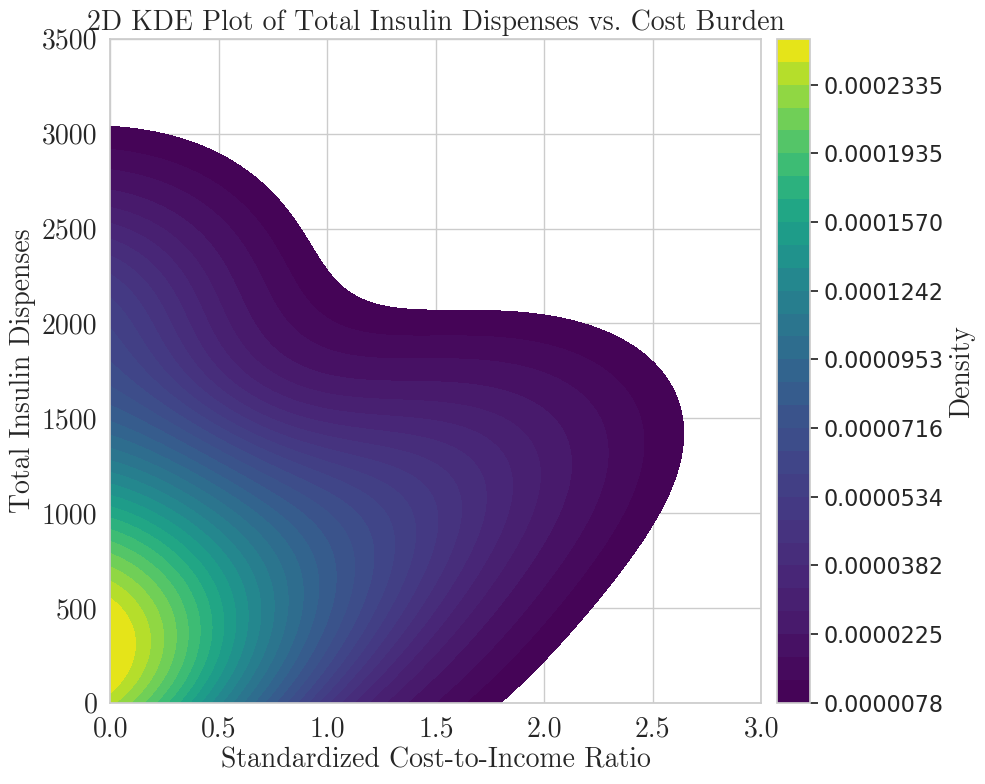

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

# Load the .ttf file — make sure 'cmunrm.ttf' is uploaded
font_path = "cmunrm.ttf"
cm_font_title = fm.FontProperties(fname=font_path, size=20)
cm_font_labels = fm.FontProperties(fname=font_path, size=20)
cm_font_ticks = fm.FontProperties(fname=font_path, size=20)

# Optional: turn off LaTeX and avoid any math font clashes
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['axes.unicode_minus'] = False

# Create the plot
plt.figure(figsize=(10, 8))
sns.kdeplot(
    data=df,
    x='cost_income_std',
    y='total_dispenses',
    fill=True,
    cmap="inferno",
    levels=30,
    thresh=0.05,
    clip=((0, 3), (df['total_dispenses'].min(), df['total_dispenses'].max()))
)

plt.xlim(0, 3)
plt.ylim(0, 3500)

# Apply custom fonts
plt.title("2D KDE Plot of Total Insulin Dispenses vs. Cost Burden", fontproperties=cm_font_title)
plt.xlabel("Standardized Cost-to-Income Ratio", fontproperties=cm_font_labels)
plt.ylabel("Total Insulin Dispenses", fontproperties=cm_font_labels)
plt.xticks(fontproperties=cm_font_ticks)
plt.yticks(fontproperties=cm_font_ticks)

# Layout and save
plt.tight_layout()
plt.savefig("KDE.pdf", dpi=300)
plt.show()
o